In [ ]:
# Needed: 
# uv pip install trimesh
# uv pip install cartopy
# uv pip install nbformat ipykernel ipython

In [2]:
from anemoi.graphs.generate.tri_icosahedron import get_latlon_coords_icosphere, create_nx_graph_from_tri_coords, create_node_neighbours_list, get_neighbours_within_hops
from anemoi.graphs.generate.utils import get_coordinates_ordering
import matplotlib.pyplot as plt
import cartopy
import networkx as nx
from sklearn.neighbors import BallTree
import numpy as np
import trimesh
from anemoi.graphs.generate.transforms import cartesian_to_latlon_rad
from anemoi.graphs.generate.masks import KNNAreaMaskBuilder

/Users/michelecattaneo/Documents/SDSC/S-RUC/graph_imprinting/graph_imprinting/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
resol = 2
resol_lam = resol + 2

In [24]:
lat_min, lat_max = 10, 50   # degrees
lon_min, lon_max = 10, 50 # degrees


In [25]:
def get_mask(x):
    lats = np.degrees(x[:,0])
    lons = np.degrees(x[:,1])

    mask = (lats >= lat_min) & (lats <= lat_max) & \
        (lons >= lon_min) & (lons <= lon_max)
    
    return mask

In [26]:
icosphere_glob = get_latlon_coords_icosphere(resolution=resol)
node_ordering = get_coordinates_ordering(icosphere_glob)

In [27]:
lats = np.degrees(icosphere_glob[:,0])
lons = np.degrees(icosphere_glob[:,1])

mask_glob = (lats >= lat_min) & (lats <= lat_max) & \
       (lons >= lon_min) & (lons <= lon_max)

# mask_glob = get_mask(x=icosphere_glob)
# mask_glob = ~mask_glob

In [28]:
icosphere_lam = get_latlon_coords_icosphere(resolution=resol_lam)
node_ordering_lam = get_coordinates_ordering(icosphere_lam)

In [29]:
lats = np.degrees(icosphere_lam[:,0])
lons = np.degrees(icosphere_lam[:,1])

mask_lam = (lats >= lat_min) & (lats <= lat_max) & \
       (lons >= lon_min) & (lons <= lon_max)

# mask_lam = get_mask(x=icosphere_lam)

In [30]:
coords_rad = np.concatenate([icosphere_glob[~mask_glob], icosphere_lam[mask_lam]], axis=0)

In [31]:
node_ordering = get_coordinates_ordering(coords_rad)

In [32]:
nx_graph = create_nx_graph_from_tri_coords(coords_rad, node_ordering)

In [ ]:
# This function is taken from Anemoi.graphs.src.anemoi.graphs.generate
# KNNAreaMaskBuilder is not used. 

def add_edges_to_nx_graph(
    graph: nx.DiGraph,
    resolutions: list[int],
    x_hops: int = 1,
    mask_in: bool = True
) -> nx.DiGraph:

    assert x_hops > 0, "x_hops == 0, graph would have no edges ..."

    graph_vertices = np.array([graph.nodes[i]["hcoords_rad"] for i in sorted(graph.nodes)])
    tree = BallTree(graph_vertices, metric="haversine")

    # Build the multi-scale connections
    for resolution in resolutions:
        # Define the coordinates of the isophere vertices at specified 'resolution' level
        r_sphere = trimesh.creation.icosphere(subdivisions=resolution, radius=1.0)
        r_vertices_rad = cartesian_to_latlon_rad(r_sphere.vertices)

        # Limit area of mesh points.
        # if area_mask_builder is not None:
        #     area_mask = area_mask_builder.get_mask(r_vertices_rad)

        area_mask = get_mask(r_vertices_rad)
        if not mask_in:
            area_mask = ~area_mask
        valid_nodes = np.where(area_mask)[0]
        # TODO check if masking is needed
        valid_nodes = None


        node_neighbours = get_neighbours_within_hops(r_sphere, x_hops, valid_nodes=valid_nodes)

        _, vertex_mapping_index = tree.query(r_vertices_rad, k=1)
        neighbour_pairs = create_node_neighbours_list(graph, node_neighbours, vertex_mapping_index)
        graph.add_edges_from(neighbour_pairs)
    return graph

In [34]:
# graph = add_edges_to_nx_graph(graph=nx_graph, resolutions=list(range(1, resol+1)), mask_in=False)
graph = add_edges_to_nx_graph(graph=nx_graph, resolutions=list(range(1, resol_lam+1)), mask_in=True)

In [35]:
x = coords_rad
edges = np.array(nx_graph.edges)

In [36]:
len(graph.edges)

2034

In [37]:
nx_graph.edges

OutEdgeView([(18, 4), (18, 5), (18, 29), (18, 30), (18, 38), (18, 39), (18, 59), (18, 60), (18, 103), (18, 107), (18, 143), (18, 148), (18, 18), (60, 5), (60, 18), (60, 105), (60, 107), (60, 145), (60, 148), (60, 60), (59, 4), (59, 18), (59, 100), (59, 103), (59, 140), (59, 143), (59, 59), (107, 18), (107, 30), (107, 60), (107, 103), (107, 105), (107, 108), (107, 107), (107, 166), (148, 18), (148, 39), (148, 60), (148, 143), (148, 145), (148, 150), (148, 148), (143, 18), (143, 38), (143, 59), (143, 140), (143, 148), (143, 150), (143, 143), (103, 18), (103, 29), (103, 59), (103, 100), (103, 107), (103, 108), (103, 103), (140, 4), (140, 38), (140, 46), (140, 59), (140, 142), (140, 143), (140, 140), (145, 5), (145, 39), (145, 53), (145, 60), (145, 147), (145, 148), (145, 145), (105, 5), (105, 30), (105, 56), (105, 60), (105, 106), (105, 107), (105, 105), (105, 197), (105, 168), (100, 4), (100, 29), (100, 49), (100, 59), (100, 102), (100, 103), (100, 100), (150, 38), (150, 39), (150, 141),

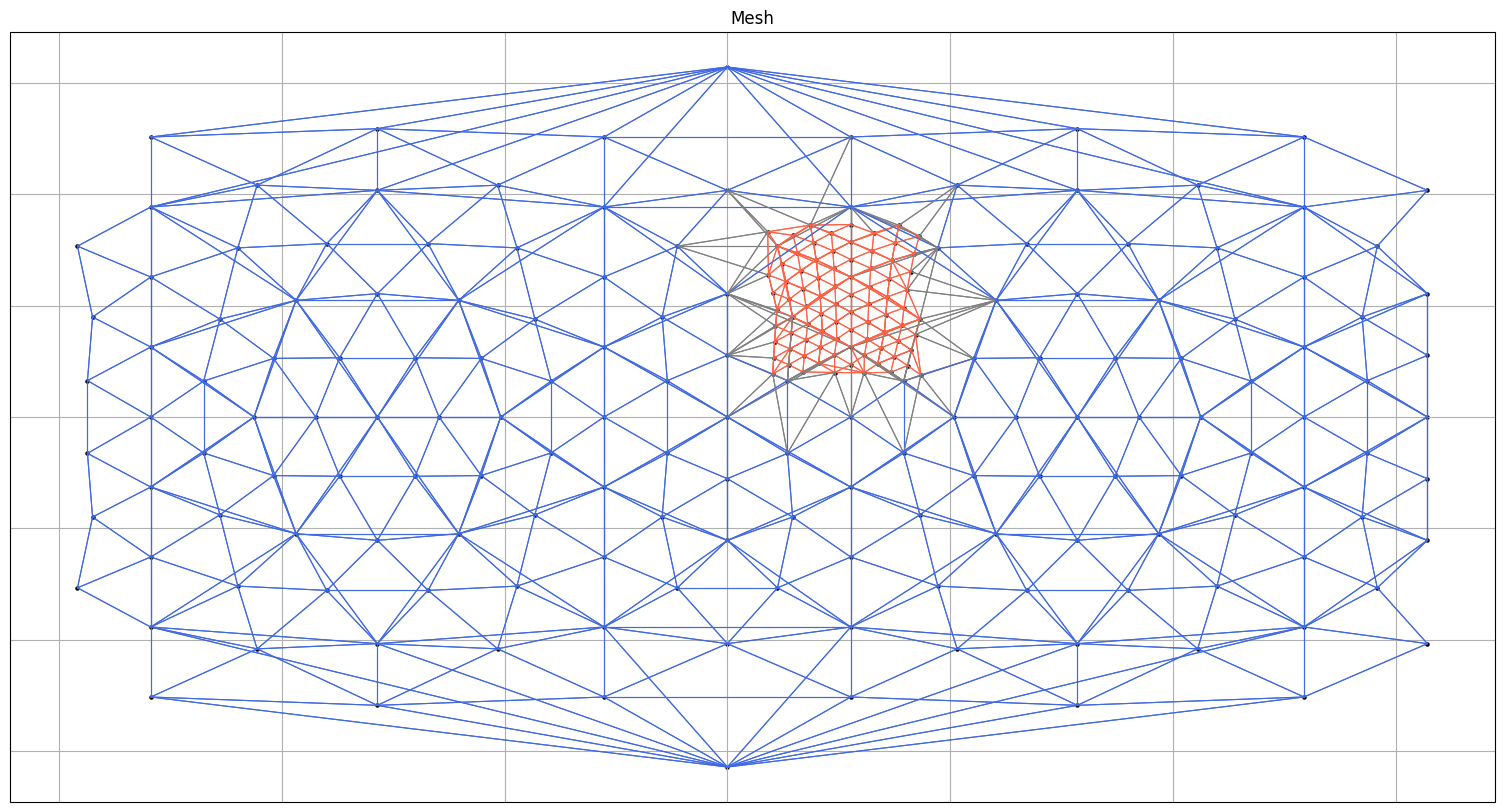

In [38]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

lats = x[:,0]
lons = x[:,1]

plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()

# --- draw nodes ---
ax.scatter(lons, lats, s=5, color='black',
           transform=ccrs.PlateCarree())

plt.title("Mesh")


mask_plot = get_mask(x)

#--- draw edges ---
for i, j in edges:
    lat_pair = [lats[i], lats[j]]
    lon_pair = [lons[i], lons[j]]
    
    lon_pair_deg = np.degrees(lon_pair)
    if np.abs(lon_pair_deg[1] - lon_pair_deg[0]) > 180:
        # skip this edge
        continue
    if mask_plot[i] and mask_plot[j]:
        color = 'tomato'
    elif not mask_plot[i] and not mask_plot[j]:
        color = 'royalblue'
    else: 
        color = 'grey'
    ax.plot(lon_pair, lat_pair,
            linewidth=0.8,
            color=color,
            transform=ccrs.PlateCarree())


plt.grid(True)
plt.show()

In [ ]:
import numpy as np


# 3D Cartesian coordinates for all nodes from the 2d latlon
cartesian_pos = {}
for n, data in enumerate(x):
    lat, lon = data 
    x = np.cos(lat) * np.cos(lon)
    y = np.cos(lat) * np.sin(lon)
    z = np.sin(lat)
    cartesian_pos[n] = (x, y, z)


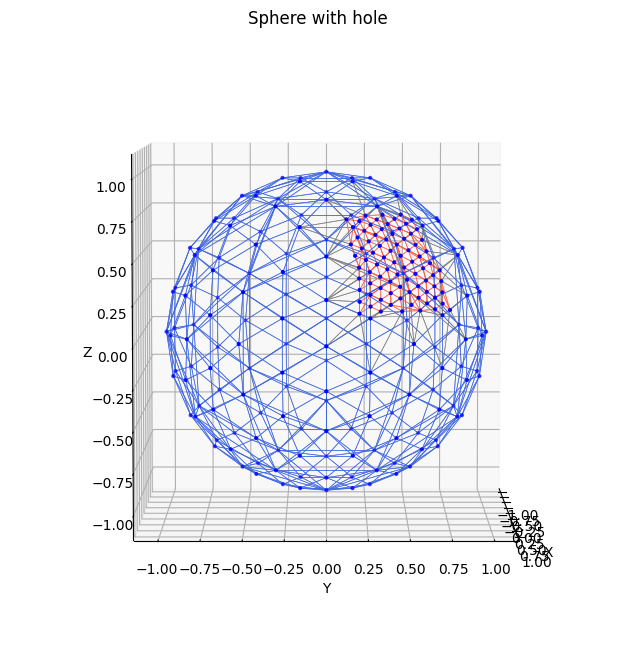

In [42]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

# draw edges
for u, v in edges:

    if mask_plot[u] and mask_plot[v]:
        color = 'tomato'
    elif not mask_plot[u] and not mask_plot[v]:
        color = 'royalblue'
    else: 
        color = 'grey'

    x_pair = [cartesian_pos[u][0], cartesian_pos[v][0]]
    y_pair = [cartesian_pos[u][1], cartesian_pos[v][1]]
    z_pair = [cartesian_pos[u][2], cartesian_pos[v][2]]
    ax.plot(x_pair, y_pair, z_pair, color=color, alpha=0.9, linewidth=0.5)

# draw nodes
x_nodes = [c[0] for c in cartesian_pos.values()]
y_nodes = [c[1] for c in cartesian_pos.values()]
z_nodes = [c[2] for c in cartesian_pos.values()]
ax.scatter(x_nodes, y_nodes, z_nodes, color='blue', s=4)


ax.set_box_aspect([1,1,1])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title("Sphere with hole")
elev = 5 
azim = 0
ax.view_init(elev=elev, azim=azim)
plt.show()


In [43]:
import numpy as np
import plotly.graph_objs as go

# collect edge coords
edge_traces = []
for u, v in edges:
    if mask_plot[u] and mask_plot[v]:
        color = 'tomato'
    elif not mask_plot[u] and not mask_plot[v]:
        color = 'royalblue'
    else: 
        color = 'grey'

    x = [cartesian_pos[u][0], cartesian_pos[v][0], None]
    y = [cartesian_pos[u][1], cartesian_pos[v][1], None]
    z = [cartesian_pos[u][2], cartesian_pos[v][2], None]
    edge_traces.append(go.Scatter3d(
        x=x, y=y, z=z,
        mode='lines',
        line=dict(width=2, color=color),
        hoverinfo='none'
    ))

# nodes
x_nodes = [c[0] for c in cartesian_pos.values()]
y_nodes = [c[1] for c in cartesian_pos.values()]
z_nodes = [c[2] for c in cartesian_pos.values()]

node_trace = go.Scatter3d(
    x=x_nodes, y=y_nodes, z=z_nodes,
    mode='markers',
    marker=dict(size=3, color='blue')
)

import plotly.io as pio
pio.renderers.default = "notebook"

fig = go.Figure(data=edge_traces + [node_trace])
fig.update_layout(scene=dict(aspectmode='data'))
fig.show()
